In [303]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# Data Preparation

In [304]:
df = pd.read_excel('Online Retail.xlsx')
df = df.replace(to_replace="Israel", value="Palestine")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [306]:
df.notnull().sum()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [307]:
id = 1
for i in range(len(df)):
    if np.isnan(df.iloc[i, 6]):
        df.iloc[i, 6] = id
        if df.iloc[i, 0] != df.iloc[i+1, 0]:
            id += 1

In [308]:
df.notnull().sum()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     541909
Country        541909
dtype: int64

# Feature Engineering

In [309]:
def customer_shopping_report(df, id):
    customer_df = df[(df['CustomerID']==id) & (df['Quantity']>0)]
    
    if customer_df.empty:
        return False
    
    total_spend = 0
    for index, row in customer_df.iterrows():
        total_spend += row['UnitPrice'] * row['Quantity']
        
    freq_order = len(customer_df['InvoiceNo'].unique())
    avg_basket_size = sum(customer_df['Quantity']) / freq_order
    country = customer_df['Country'].iloc[0]
    
    return [id, total_spend, avg_basket_size, freq_order, country]

In [310]:
seg_df = pd.DataFrame(columns=['ID', 'TotalSpend', 'AvgBasketSize', 'FreqOrder', 'Country'])

customer_id_unique = df['CustomerID'].unique()
for id in customer_id_unique:
    if customer_shopping_report(df, id) != False:
        seg_df.loc[len(seg_df)] = customer_shopping_report(df, id)
    
seg_df.head()

,ID,TotalSpend,AvgBasketSize,FreqOrder,Country
0,17850.0,5391.21,50.970588,34,United Kingdom
1,13047.0,3237.54,139.100000,10,United Kingdom
2,12583.0,7281.38,337.333333,15,France
3,13748.0,948.25,87.800000,5,United Kingdom
4,15100.0,876.00,26.666667,3,United Kingdom


In [311]:
seg_df.describe()

,ID,TotalSpend,AvgBasketSize,FreqOrder
count,6531.000000,6531.000000,6531.000000,6531.000000
mean,10780.751493,1629.851542,243.673408,3.173787
std,6542.180743,7467.716324,1135.537221,6.467705
min,1.000000,-11062.060000,1.000000,1.000000
25%,2723.000000,130.245000,49.000000,1.000000
50%,13801.000000,501.120000,131.000000,1.000000
75%,16032.000000,1456.875000,269.305556,3.000000
max,18287.000000,280206.020000,74215.000000,210.000000


In [312]:
def remove_outliers(df, col_name):
    percentile25 = df[col_name].quantile(0.25)
    percentile75 = df[col_name].quantile(0.75)
    
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    return df[(df[col_name]<upper_limit) & (df[col_name]>lower_limit)]

<AxesSubplot:ylabel='FreqOrder'>

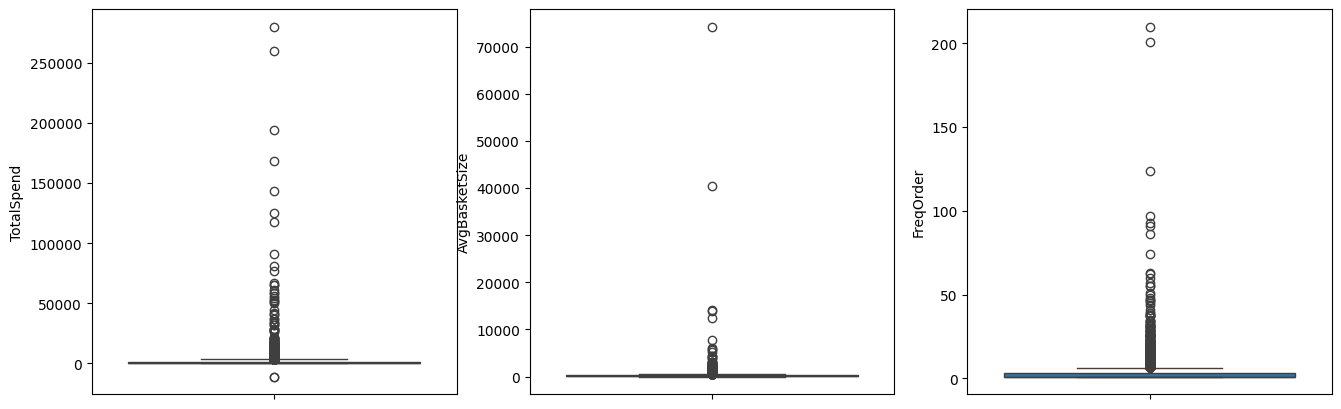

In [313]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(seg_df['TotalSpend'], ax=axes[0])
sns.boxplot(seg_df['AvgBasketSize'], ax=axes[1])
sns.boxplot(seg_df['FreqOrder'], ax=axes[2])

In [314]:
seg_df = remove_outliers(seg_df, 'TotalSpend')
seg_df = remove_outliers(seg_df, 'AvgBasketSize')
seg_df = remove_outliers(seg_df, 'FreqOrder')

<AxesSubplot:ylabel='FreqOrder'>

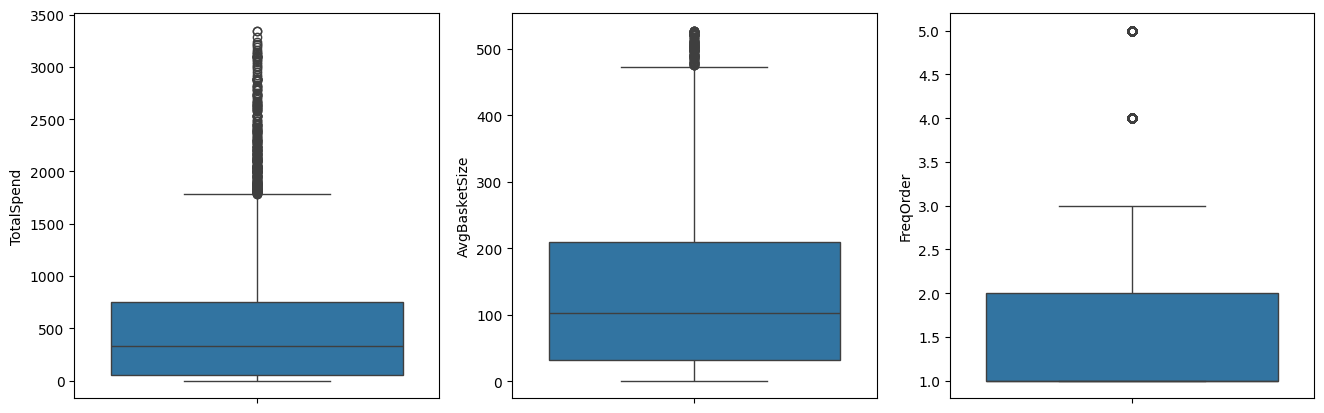

In [315]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(seg_df['TotalSpend'], ax=axes[0])
sns.boxplot(seg_df['AvgBasketSize'], ax=axes[1])
sns.boxplot(seg_df['FreqOrder'], ax=axes[2])

In [316]:
nseg_df = seg_df.reset_index()
nseg_df

,index,ID,TotalSpend,AvgBasketSize,FreqOrder,Country
0,3,13748.0,948.25,87.800000,5,United Kingdom
1,4,15100.0,876.00,26.666667,3,United Kingdom
2,11,18074.0,489.60,190.000000,1,United Kingdom
3,12,17420.0,598.83,88.333333,3,United Kingdom
4,14,16250.0,389.44,104.000000,2,United Kingdom
...,...,...,...,...,...,...
5151,6522,3703.0,0.00,20.000000,1,United Kingdom
5152,6523,14569.0,227.39,79.000000,1,United Kingdom
5153,6524,3705.0,17.90,14.000000,1,United Kingdom
5154,6525,3706.0,3.35,2.000000,1,United Kingdom


# Dimensionality Reduction with PCA

In [317]:
x = nseg_df.drop(columns=['index', 'ID', 'FreqOrder', 'Country'], axis=1)
y = nseg_df['ID']
x_scl = StandardScaler().fit_transform(x)

In [318]:
y

0       13748.0
1       15100.0
2       18074.0
3       17420.0
4       16250.0
         ...   
5151     3703.0
5152    14569.0
5153     3705.0
5154     3706.0
5155    12713.0
Name: ID, Length: 5156, dtype: float64

In [319]:
x

,TotalSpend,AvgBasketSize
0,948.25,87.800000
1,876.00,26.666667
2,489.60,190.000000
3,598.83,88.333333
4,389.44,104.000000
...,...,...
5151,0.00,20.000000
5152,227.39,79.000000
5153,17.90,14.000000
5154,3.35,2.000000


In [355]:
dim_red = PCA()
x_pca = dim_red.fit_transform(x_scl)
dim_red.explained_variance_ratio_

array([0.84339125, 0.15660875])

In [356]:
dim_red.get_feature_names_out()

array(['pca0', 'pca1'], dtype=object)

In [357]:
df_pca = pd.DataFrame(x_pca, columns=dim_red.get_feature_names_out())
df_pca

,pca0,pca1
0,0.210656,-0.766201
1,-0.212027,-1.020461
2,0.241916,0.334221
3,-0.193659,-0.355980
4,-0.350974,-0.025185
...,...,...
5151,-1.269962,-0.036347
5152,-0.678267,0.025278
5153,-1.282319,-0.090430
5154,-1.365717,-0.139910


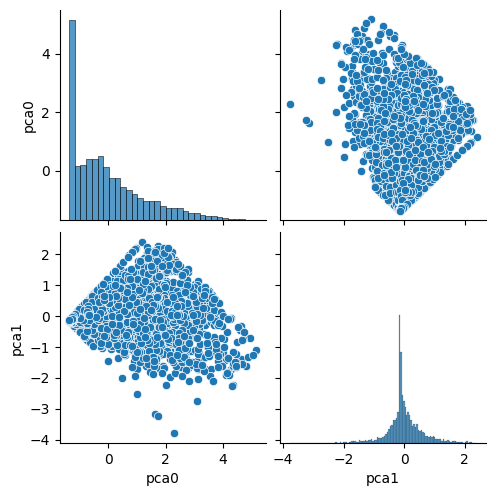

In [358]:
sns.pairplot(df_pca)

<AxesSubplot:ylabel='pca1'>

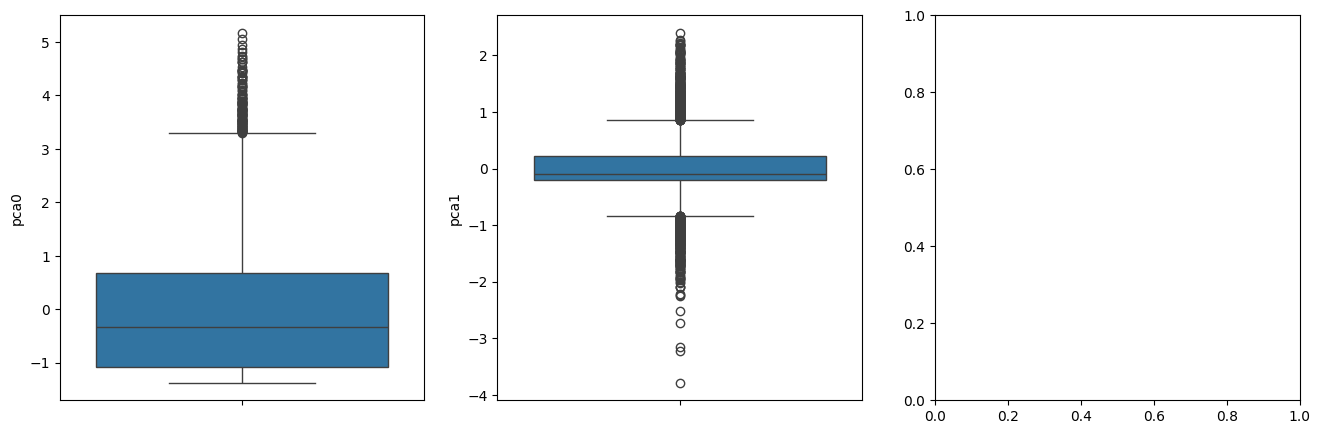

In [359]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(df_pca['pca0'], ax=axes[0])
sns.boxplot(df_pca['pca1'], ax=axes[1])
#sns.boxplot(df_pca['pca2'], ax=axes[2])

In [360]:
df_pca['ID'] = y

df_pca = remove_outliers(df_pca, 'pca0')
df_pca = remove_outliers(df_pca, 'pca1')
#df_pca = remove_outliers(df_pca, 'pca2')

y_pca = df_pca['ID']
df_pca = df_pca.drop(columns=['ID'], axis=1)

<AxesSubplot:ylabel='pca1'>

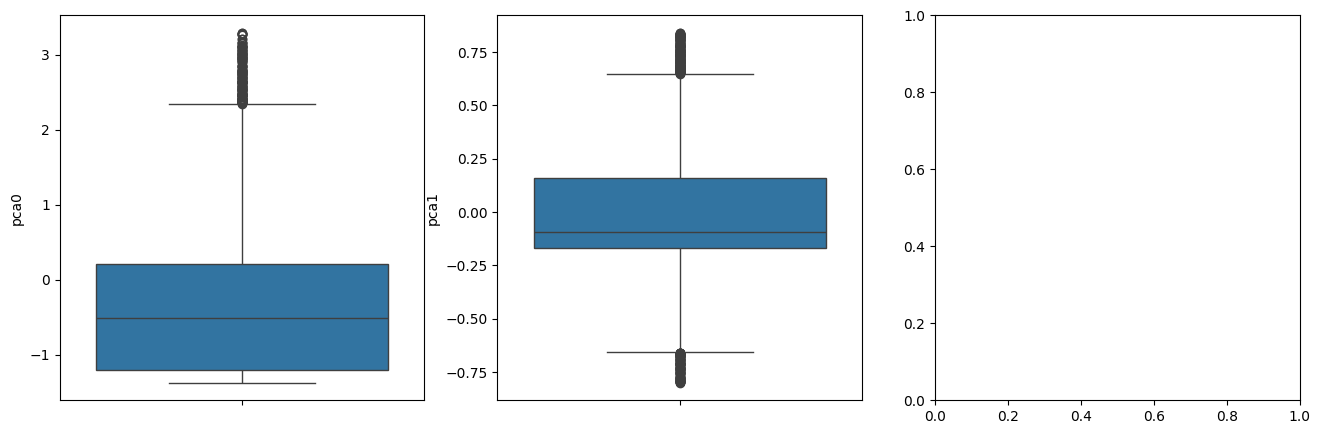

In [361]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(df_pca['pca0'], ax=axes[0])
sns.boxplot(df_pca['pca1'], ax=axes[1])
#sns.boxplot(df_pca['pca2'], ax=axes[2])

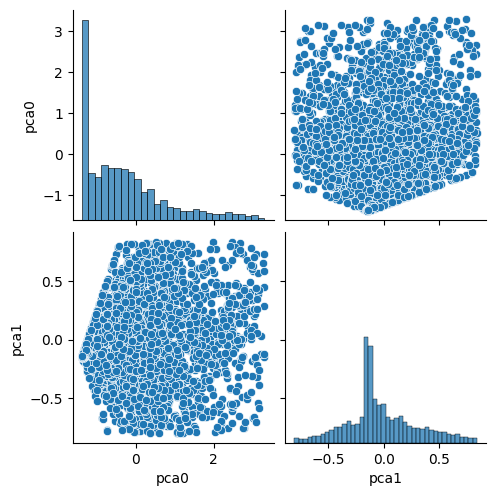

In [362]:
sns.pairplot(df_pca)

# Determining Optimal Number of Clusters

In [363]:
list_of_inirtias = []
for n in range(1,20):
    km = KMeans(n_clusters=n)
    km.fit(df_pca)
    list_of_inirtias.append(km.inertia_)
    print(n, km.inertia_)

1 5494.574240022293
2 2046.1398256351179
3 1092.592636697743
4 795.9782819795671
5 644.8582760743564
6 495.05667194986717
7 424.7443105242291
8 364.4706396487109
9 320.79528433355347
10 286.98315464069606
11 264.99924459338786
12 245.41871134825536
13 227.21187310508367
14 210.8290317487823
15 197.30992505693456
16 185.46067540541767
17 170.77839863905984
18 161.0615952579361
19 151.1621816950759


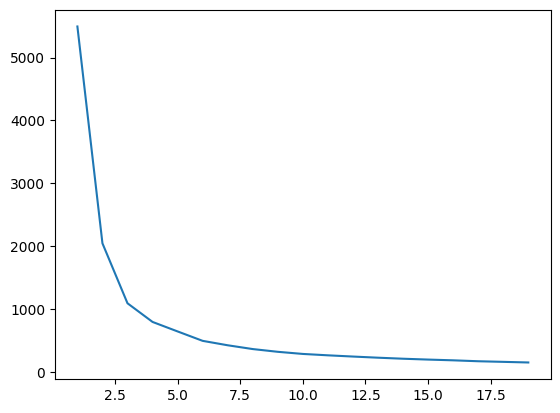

In [364]:
plt.plot(range(1,20), list_of_inirtias)

# K-means Clustering

In [365]:
agg = AgglomerativeClustering(n_clusters=2)
predictions = agg.fit_predict(df_pca)

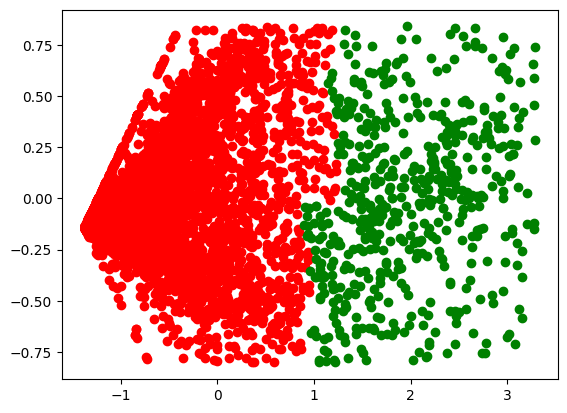

In [366]:
plt.scatter(df_pca.iloc[predictions==0,0], df_pca.iloc[predictions==0,1], color='red')
plt.scatter(df_pca.iloc[predictions==1,0], df_pca.iloc[predictions==1,1], color='green')
#plt.scatter(df_pca.iloc[predictions==2,0], df_pca.iloc[predictions==2,1], color='blue')

#  Cluster Profiling

In [367]:
df_pca['ID'] = y_pca
df_pca

,pca0,pca1,ID
0,0.210656,-0.766201,13748.0
2,0.241916,0.334221,18074.0
3,-0.193659,-0.355980,17420.0
4,-0.350974,-0.025185,16250.0
5,-0.939170,0.053643,17548.0
...,...,...,...
5150,-0.429581,-0.035164,13298.0
5151,-1.269962,-0.036347,3703.0
5152,-0.678267,0.025278,14569.0
5153,-1.282319,-0.090430,3705.0


In [374]:
id_0 = df_pca.iloc[predictions==0,2]
id_0

0       13748.0
2       18074.0
3       17420.0
4       16250.0
5       17548.0
         ...   
5150    13298.0
5151     3703.0
5152    14569.0
5153     3705.0
5154     3706.0
Name: ID, Length: 3888, dtype: float64

In [375]:
id_1 =  df_pca.iloc[predictions==1,2]
id_1

17      15983.0
22      17951.0
26      14001.0
71      16244.0
72      15111.0
         ...   
4676    13447.0
4825    15009.0
4974    16376.0
5031    14893.0
5058    13521.0
Name: ID, Length: 538, dtype: float64

In [384]:
df_0 = nseg_df[(nseg_df['ID'].isin(id_0))].drop(columns=['index', 'ID'], axis=1)
df_0

,TotalSpend,AvgBasketSize,FreqOrder,Country
0,948.25,87.800000,5,United Kingdom
2,489.60,190.000000,1,United Kingdom
3,598.83,88.333333,3,United Kingdom
4,389.44,104.000000,2,United Kingdom
5,103.30,58.000000,1,United Kingdom
...,...,...,...,...
5150,360.00,96.000000,1,United Kingdom
5151,0.00,20.000000,1,United Kingdom
5152,227.39,79.000000,1,United Kingdom
5153,17.90,14.000000,1,United Kingdom


In [385]:
df_1 = nseg_df[(nseg_df['ID'].isin(id_1))].drop(columns=['index', 'ID'], axis=1)
df_1

,TotalSpend,AvgBasketSize,FreqOrder,Country
17,1475.02,223.000000,4,United Kingdom
22,1008.54,205.333333,3,United Kingdom
26,2043.08,320.666667,3,United Kingdom
71,1522.75,427.500000,2,United Kingdom
72,1567.48,236.666667,3,United Kingdom
...,...,...,...,...
4676,1129.14,194.666667,3,United Kingdom
4825,1261.78,214.000000,3,United Kingdom
4974,987.01,347.000000,2,United Kingdom
5031,1237.85,399.500000,2,United Kingdom
